## Aircraft Detection in very high resolution satellite images with YOLOv8

Author: Fabian Löw
Date: August 2023

### Problem Setting
Aircraft detection from Earth observation satellite images is crucial for monitoring airport activities and mapping aircraft locations. While manual digitization is accurate, it becomes impractical for large regions or when fast assessments are required.

### Proposed Solution
In this project, we test the YOLOv8 deep learning method to detect aircraft in high-resolution satellite images from Airbus' Pleiades twin satellites. YOLOv8 is a state-of-the-art object detection algorithm that has shown promising results in various applications. Inspiration for this test stems from Jeff Faudi´s code on [Kaggle](https://www.kaggle.com/code/jeffaudi/aircraft-detection-with-yolov5).

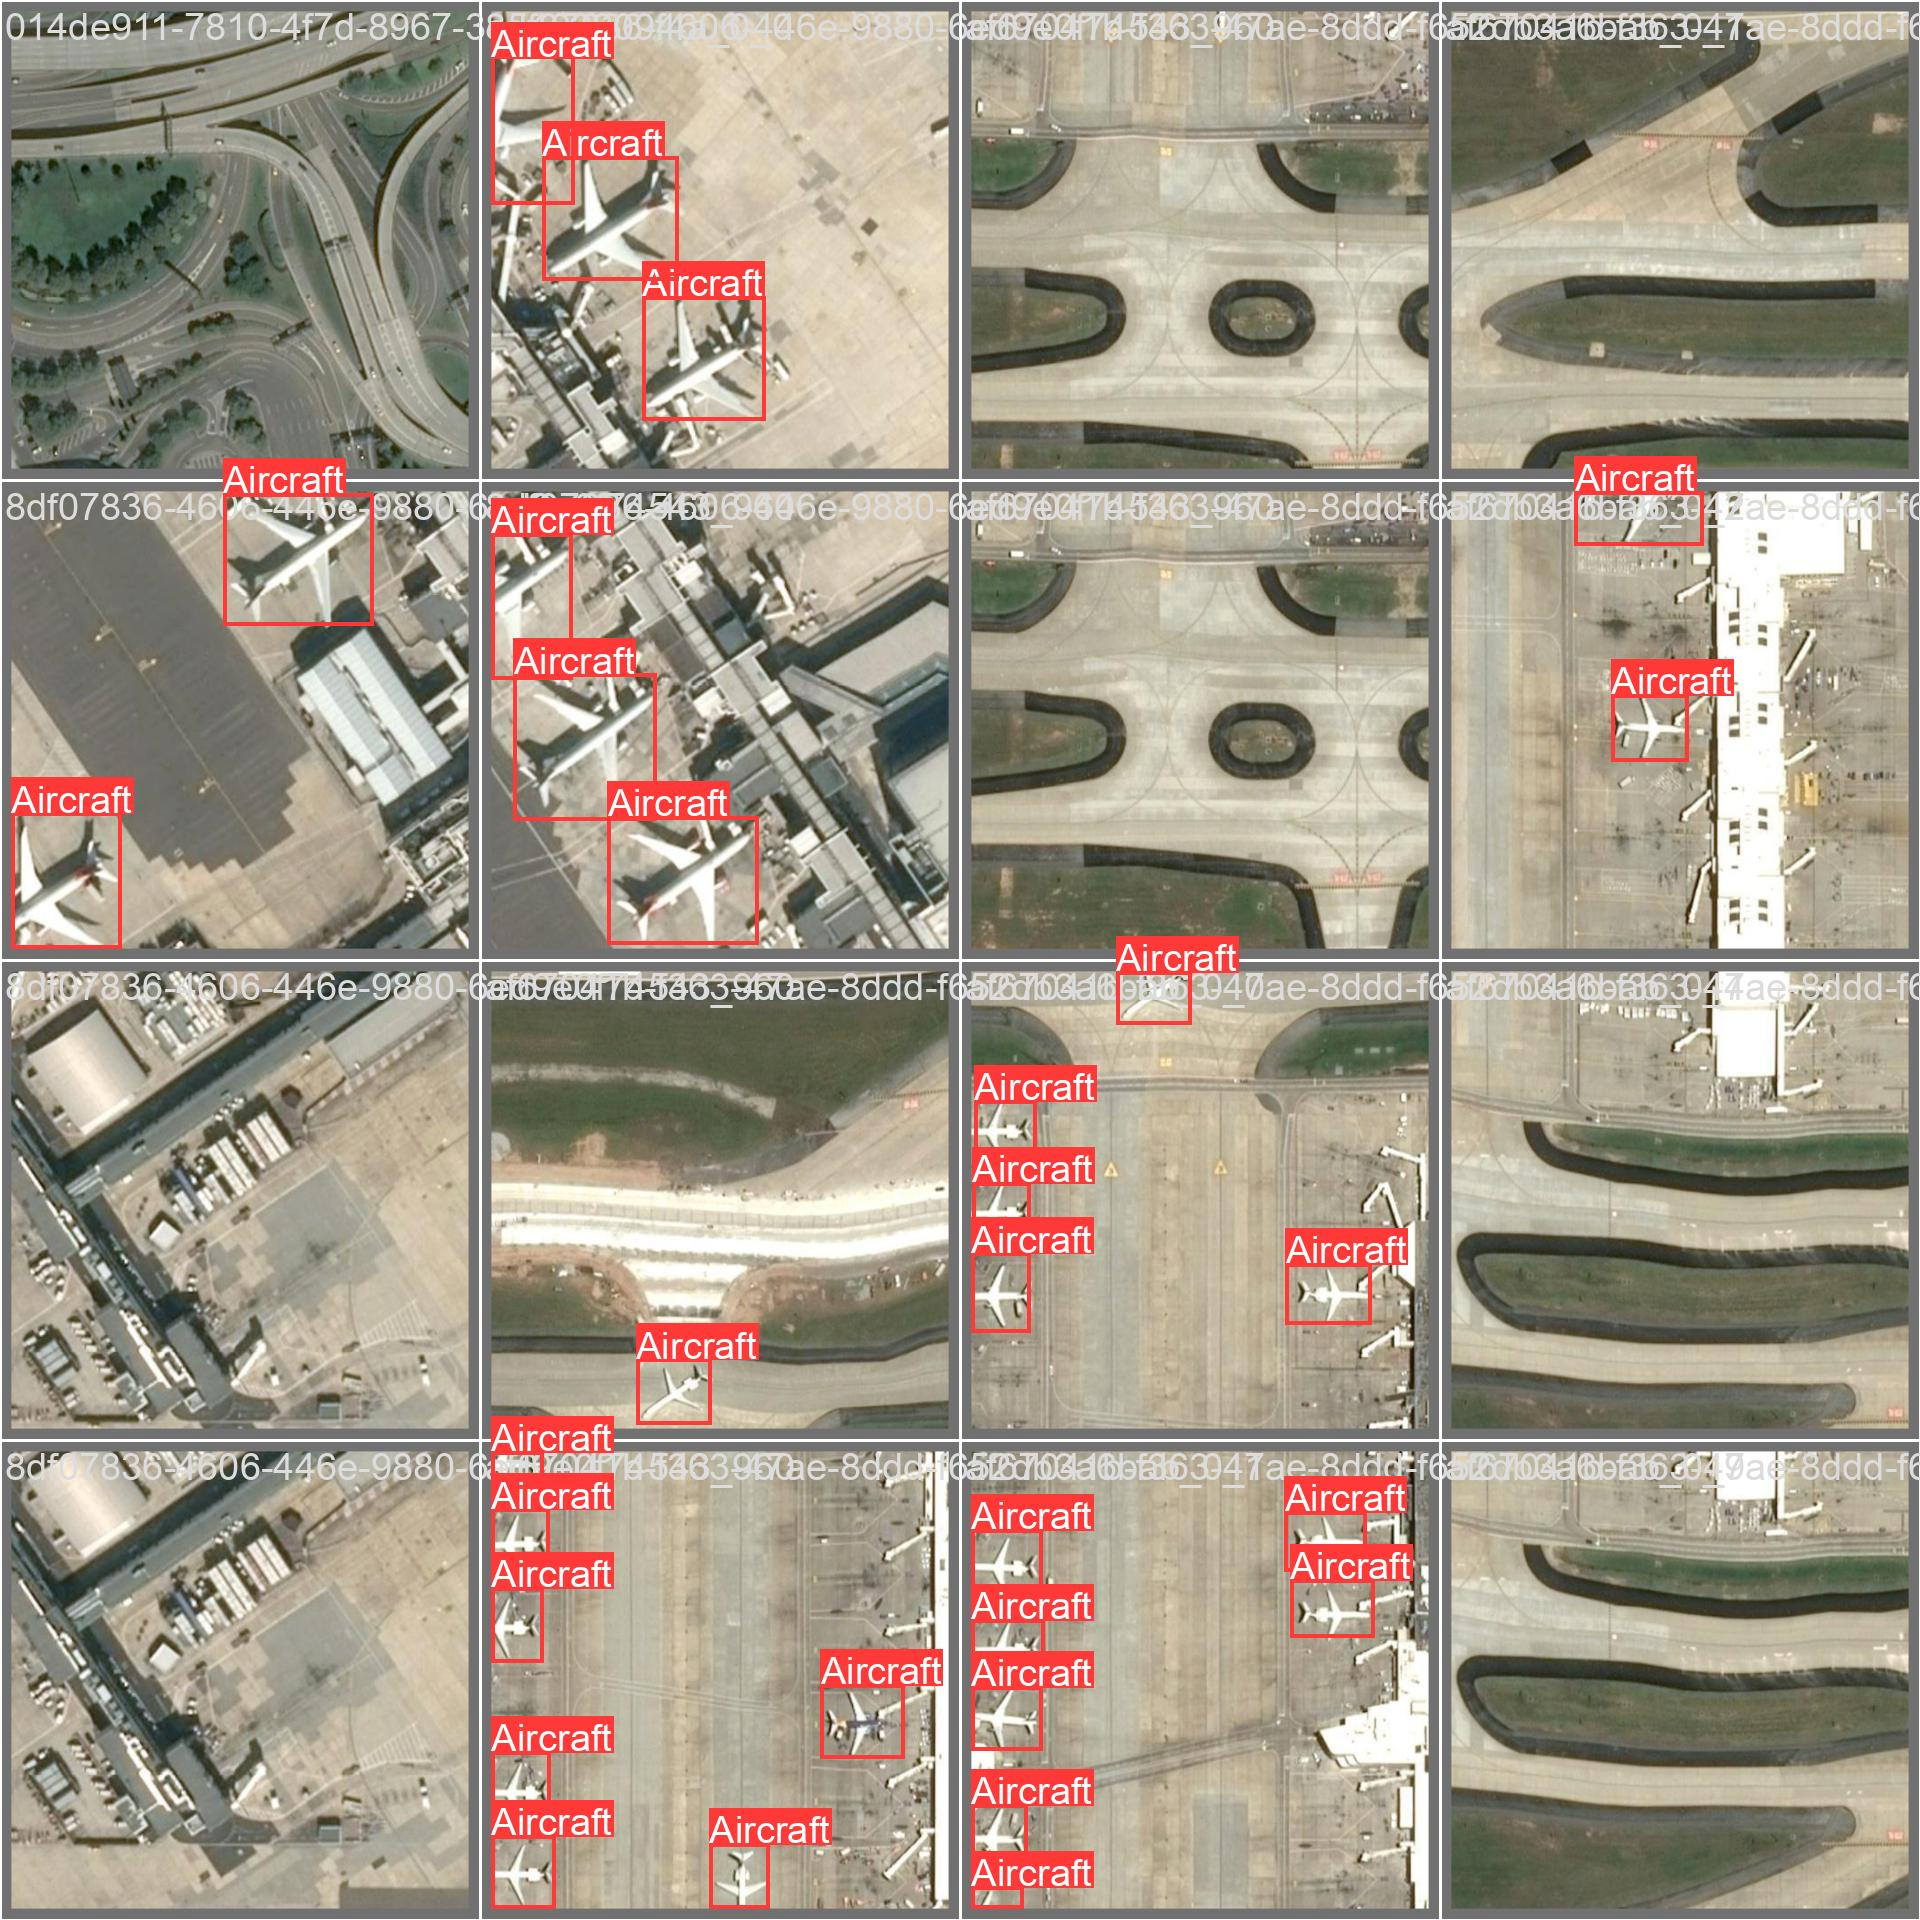

### Methodological Steps
1. Data Collection: We used the Airbus Intelligence dataset available on Kaggle, which contains satellite images of airports along with labeled aircraft objects.

2. Image Preprocessing: The satellite images were preprocessed to extract relevant tiles and their corresponding annotations for training the YOLOv8 model.

3. Data Augmentation: To increase the training data and improve model generalization, we applied various data augmentation techniques such as rotation, flipping, and scaling.

4. Model Calibration: We trained the YOLOv8 model on the preprocessed data to accurately detect aircraft in the satellite images.

5. Model Evaluation: After training, we evaluated the model's performance using metrics like box loss, class loss, precision, recall, and mAP.

6. Inference: The calibrated YOLOv8 model was applied to new satellite images for real-time aircraft detection.

You can add the additional information to your README.md as follows:

### Technical Details
The workflow was implemented and tested in Google Colab using a GPU runtime. This allowed for faster training and inference of the YOLOv8 model on the high-resolution satellite images.

To replicate this project and run the code successfully, the following technical requirements are recommended:

- Google Colab with GPU runtime: The GPU runtime provides significant speedup during model training and inference. It can be enabled in Google Colab under "Runtime" > "Change runtime type" > "GPU".

- Python Environment: The code was developed and tested in Python, so a working Python environment is required. The necessary packages and libraries can be installed using the provided "requirements.txt" file.

- Data Access: Ensure that the Airbus Intelligence dataset is accessible from your working directory in Google Colab. You can upload the dataset to Google Drive or directly to the Colab session.

- Model Calibration: For model calibration, the YOLOv8 model weights file ("yolov8n.pt" or "yolov8s.pt") should be available in the working directory.

- Data Preprocessing: The data preprocessing steps outlined in the code should be followed to prepare the dataset for training.

With these technical details in place, you should be able to replicate the aircraft detection workflow using YOLOv8 on Earth observation satellite images.

Please refer to the code documentation and comments for any additional information on the implementation and usage of the functions provided in this repository.

### Data Sets
The Airbus Intelligence dataset available on [Kaggle](https://www.kaggle.com/datasets/airbusgeo/airbus-aircrafts-sample-dataset) was used for this project. The dataset includes high-resolution satellite images of airports, along with corresponding annotations of aircraft objects.

For more details, you can visit the [YOLOv8 official website](https://ultralytics.com/yolov8) and the [GitHub repository](https://github.com/ultralytics/ultralytics).

*Please note that this is a summary of the steps and methods used in the project. For a detailed implementation, refer to the code and documentation provided in the repository.*

In [1]:
# First, mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Adjust the current working directory, if required
import os
os.chdir('/content/drive/MyDrive/ColabNotebooks/aircraft-detection_with_yolov8')

In [46]:
# Load the autoreload extension for automatically reloading imported modules
%load_ext autoreload
%autoreload 2

# Import the required libraries and modules
import cv2
import ast
import PIL
from PIL import Image
import shutil
import tqdm.notebook
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import display, clear_output
from ipywidgets import interact, widgets

# Import the necessary functions and classes from utils.py and config.py
import utils
from config import Config

# Create a Config object to access configuration parameters from config.py
config = Config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: Load and Preprocess the Dataset

In [4]:
# Define the path to your data folder containing images
IMAGE_PATH = config.image_folder

# Create the dropdown menu
dropdown_menu = utils.create_image_dropdown(IMAGE_PATH)

# Display the dropdown menu
display(dropdown_menu)

Dropdown(description='Select an image:', options=('0641acc3-c0b9-4f9d-b0ba-7ad18aa08864.jpg', '495b73c8-024f-4…

In [5]:
# Get the list of all jpg files in the folder
jpg_files = [file for file in os.listdir(IMAGE_PATH) if file.lower().endswith('.jpg')]
file_paths = [os.path.join(IMAGE_PATH, file_name) for file_name in jpg_files]

# Print the number of JPG files
print("Number of files:", len(jpg_files))

# Get the details of the first JPG file
if jpg_files:
    first_image_path = os.path.join(IMAGE_PATH, jpg_files[0])
    num_channels, width, height = utils.get_image_details(first_image_path)

    # Print the image details
    print("Image Height:", height)
    print("Image Width:", width)
    print("Number of Channels:", num_channels)
else:
    print("No files found in the folder.")


Number of files: 103
Image Height: 2560
Image Width: 2560
Number of Channels: 3


In [6]:
# Define the path to the "annotations.csv" file
FILE_PATH = config.data_folder
annotations_file_path = os.path.join(FILE_PATH, "annotations.csv")

# Function to convert the "geometry" column to a list of tuples
def convert_geometry(geometry_str):
    return ast.literal_eval(geometry_str)

# Load the CSV file and apply the necessary conversions
annotations_df = pd.read_csv(annotations_file_path, converters={'geometry': convert_geometry, 'class': lambda o: 'Aircraft'})

# Create bounds, width, and height columns in annotations_df
annotations_df['bounds'], annotations_df['width'], annotations_df['height'] = zip(*annotations_df['geometry'].map(utils.calculate_bounds))

# Create a new DataFrame named annotations_df_bounds
annotations_df_bounds = annotations_df.copy()

# Display the updated DataFrame
annotations_df_bounds.head(5)


,id,image_id,geometry,class,bounds,width,height
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Aircraft,"(135, 522, 245, 600)",110,78
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Aircraft,"(1025, 284, 1125, 384)",100,100
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Aircraft,"(1058, 1503, 1130, 1568)",72,65
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Aircraft,"(813, 1518, 885, 1604)",72,86
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Aircraft,"(594, 938, 657, 1012)",63,74


In [ ]:
# Create dirs for training and validation data
for split in ['train', 'val']:
    for directory in [config.tiles_dir[split], config.labels_dir[split]]:
        os.makedirs(directory, exist_ok=True)

fold = 1
num_fold = 5
index = annotations_df_bounds['image_id'].unique()

# Calculate the start and end indices for the validation set
start_idx = len(index) * fold // num_fold
end_idx = len(index) * (fold + 1) // num_fold

# Get the validation indexes directly using NumPy slicing
val_indexes = index[start_idx:end_idx]

# Generate tiles for each image
for img_path in tqdm.notebook.tqdm(file_paths):
    utils.generate_tiles(img_path=img_path, df=annotations_df_bounds, val_indexes=val_indexes)

  0%|          | 0/103 [00:00<?, ?it/s]

In [ ]:
augmented_image_dir = os.path.join(config.data_folder, "/train_aug/images")
augmented_labels_dir = os.path.join(config.data_folder, "/train_aug/labels")


if os.path.exists(augmented_image_dir):
    print(f"Augmented image directory '{augmented_image_dir}' already exists.")
else:
    print(f"Creating augmented image directory '{augmented_image_dir}'.")
    os.makedirs(augmented_image_dir, exist_ok=True)

if os.path.exists(augmented_labels_dir):
    print(f"Augmented labels directory '{augmented_labels_dir}' already exists.")
else:
    print(f"Creating augmented labels directory '{augmented_labels_dir}'.")
    os.makedirs(augmented_labels_dir, exist_ok=True)

Augmented image directory '/train_aug/images' already exists.
Augmented labels directory '/train_aug/labels' already exists.


In [ ]:
# Apply data augmentation on YOLOv8 dataset using Albumentations Library
# Inspired by: https://github.com/muhammad-faizan-122/yolo-data-augmentation

# Define folders for the augmented training data
augmented_image_dir = os.path.join(config.data_folder, "train_aug/images")
os.makedirs(augmented_image_dir, exist_ok=True)

augmented_labels_dir = os.path.join(config.data_folder, "train_aug/labels")
os.makedirs(augmented_labels_dir, exist_ok=True)

# Create configuration file for the augmentation
CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)

inp_img_pth : data/train/images
inp_lab_pth : data/train/labels
out_img_pth : data/train_aug/images
out_lab_pth : data/train_aug/labels
transformed_file_name : aug_out

# class names
CLASSES : ['Aircraft']


"""

# Write the configuration YAML to a file
with open("constants.yaml", "w") as f:
    f.write(CONFIG)

In [ ]:
# Get a list of image files in the input image path
import yaml

with open("constants.yaml", 'r') as stream:
    CONSTANTS = yaml.safe_load(stream)

imgs = os.listdir(CONSTANTS["inp_img_pth"])

# Iterate through each image file
for img_file in imgs:
    # Extract the file name without extension
    file_name = img_file.split('.')[0]

    # Create a new file name for augmented output
    aug_file_name = file_name + "_" + CONSTANTS["transformed_file_name"]

    # Load the image
    image = cv2.imread(os.path.join(CONSTANTS["inp_img_pth"], img_file))

    # Create the path for the YOLO label file
    lab_pth = os.path.join(CONSTANTS["inp_lab_pth"], file_name + '.txt')

    # Get the list of bounding boxes from YOLO label file
    album_bboxes = get_bboxes_list(lab_pth, CONSTANTS['CLASSES'])

    # Apply augmentation and save the results
    apply_aug(image, album_bboxes, CONSTANTS["out_lab_pth"], CONSTANTS["out_img_pth"],
              aug_file_name, CONSTANTS['CLASSES'])

    print(f"Augmented image and label saved for {file_name}")

## Step 3: Model Calibration

Ultralytics YOLOv8 [@yolov8_ultralytics] is a powerful object detection software that provides state-of-the-art performance for object detection tasks.

[@yolov8_ultralytics]: Glenn Jocher and Ayush Chaurasia and Jing Qiu. Ultralytics YOLOv8. Version 8.0.0. 2023. URL: https://github.com/ultralytics/ultralytics. License: AGPL-3.0.


In [ ]:
# Create a *.yaml file with parameters for YOLOv8

CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)
train: data/train_aug_including_val

# data/train_aug
val: data/val

# number of classes
nc: 1

# class names
names: ['Aircraft']
"""

# Write the configuration YAML to a file
with open("data.yaml", "w") as f:
    f.write(CONFIG)

# Define the necessary parameters
data_yaml_path = os.path.join(os.getcwd(), "data.yaml")
epochs = 20
img_height = config.tile_height

#Call the calibrate_yolov8 function with the desired parameters
model_yolov8 = utils.train_yolov8_obj_detect(data_yaml_path,
                       epochs=epochs,
                       imgsz=config.tile_height)

Ultralytics YOLOv8.0.153 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/ColabNotebooks/aircraft-detection_with_yolov8/data.yaml, epochs=20, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, 

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX: export success ✅ 11.1s, saved as 'runs/detect/train26/weights/best.onnx' (42.6 MB)

Export complete (14.2s)
Results saved to /content/drive/MyDrive/ColabNotebooks/aircraft-detection_with_yolov8/runs/detect/train26/weights
Predict:         yolo predict task=detect model=runs/detect/train26/weights/best.onnx imgsz=640 
Validate:        yolo val task=detect model=runs/detect/train26/weights/best.onnx imgsz=640 data=/content/drive/MyDrive/ColabNotebooks/aircraft-detection_with_yolov8/data.yaml 
Visualize:       https://netron.app


## Step 4: Model Evaluation

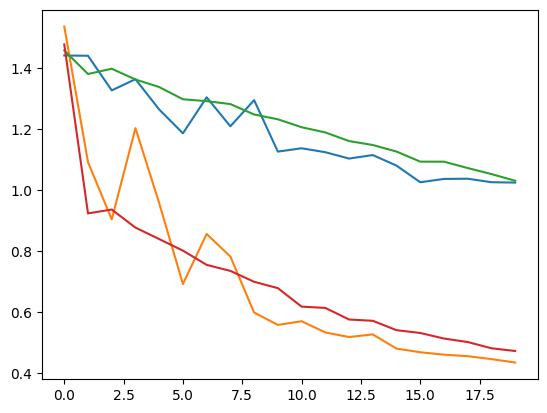

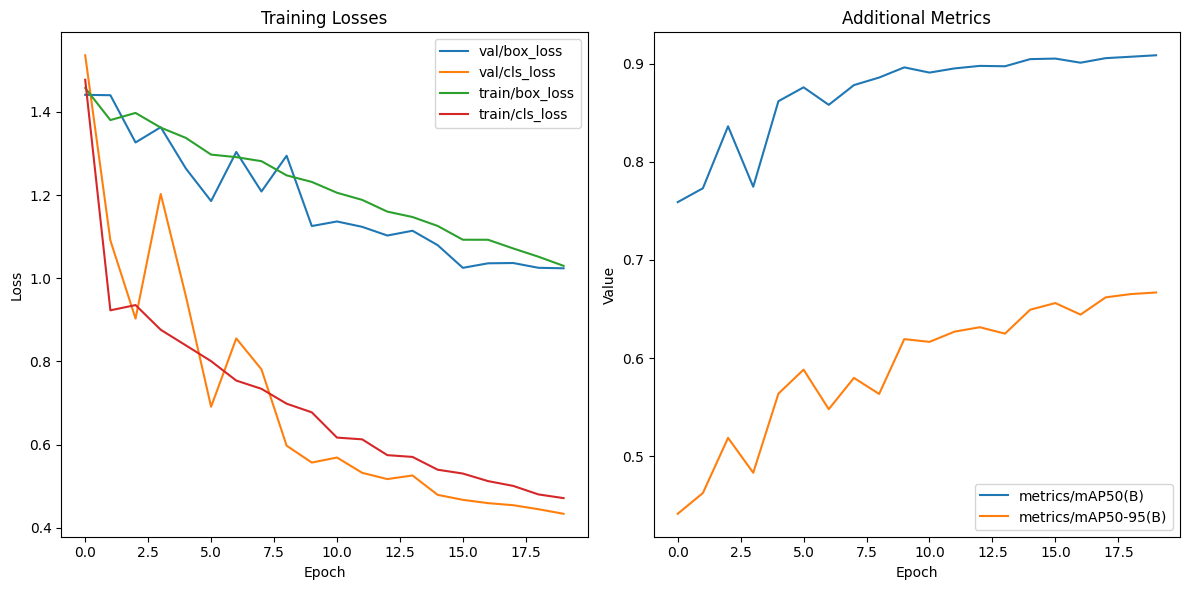

In [ ]:
# Define the path to the folder that contains the "train" folders
log_dir = os.path.join(os.getcwd(), "runs/detect")

# Automatically select the latest version of a "train" folder and plot metrics
utils.plot_losses(log_dir)

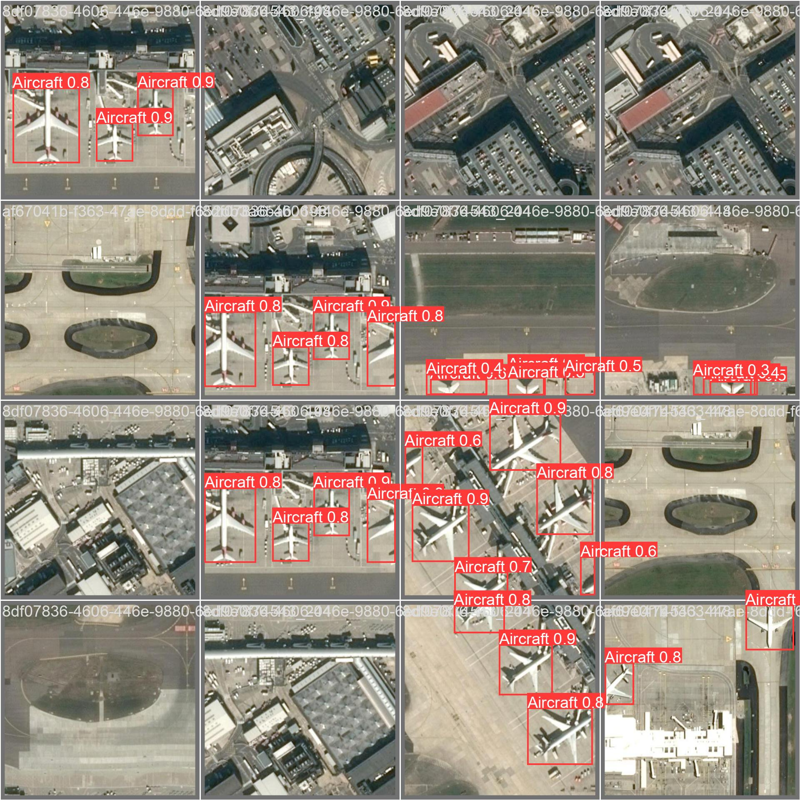

In [ ]:
# Define the path to the folder that contains the "train" folders with the val_batch example images
log_dir = os.path.join(os.getcwd(), "runs/detect")

# Visualize some random image tiles and their corresponding bounding box
utils.visualize_val_batch_images(log_dir)

# Step 6: Model Inference

In [48]:
# Create new directory for predictions
prediction_dir = os.path.join(config.data_folder, "predictions")

if os.path.exists(prediction_dir):
    print(f"Predictions directory '{prediction_dir}' already exists.")
else:
    print(f"Creating Predictions directory '{prediction_dir}'.")
    os.makedirs(prediction_dir, exist_ok=True)

# Create a dropdown menu to select an image
image_dropdown = widgets.Dropdown(options=os.listdir("data/extras"),
                                  description="Select an image:")

# Create slider widgets for conf and iou
conf_slider = widgets.FloatSlider(value=0.70, min=0.0, max=1.0,
                                  step=0.01, description="Confidence:")
iou_slider = widgets.FloatSlider(value=0.65, min=0.0, max=1.0,
                                 step=0.01, description="IOU:")

# Create a "Run" button
run_button = widgets.Button(description="Run Detection")

# Create an output widget for displaying results
output_image = widgets.Output()

# Define the function to run the detection and display results
def run_detection(b):
    output_image.clear_output()
    with output_image:
        image_filename = image_dropdown.value
        image_path = os.path.join("data/extras", image_filename)
        best_model_name = "weights/best.pt"

        # Get a list of "train" folders in the logs directory
        logs_dir = os.path.join(os.getcwd(), "runs/detect/")
        train_folders = [folder for folder in os.listdir(logs_dir) if folder.startswith('train')]

        # Sort the folders based on their modification time (latest first)
        train_folders.sort(key=lambda folder: os.path.getmtime(os.path.join(logs_dir, folder)), reverse=True)

        # Select the latest "train" folder
        latest_train_folder = train_folders[0]

        best_model_path = os.path.join(logs_dir, latest_train_folder, best_model_name)

        results, metrics = utils.load_and_apply_model(image_paths = image_path,
                                                      best_model_path = best_model_path,
                                                      conf = conf_slider.value,
                                                      iou = iou_slider.value)

        for r in results:
            im_array = r.plot()
            im = Image.fromarray(im_array[..., ::-1])
            display(im)

            # Save the predicted image with a modified filename
            output_filename = os.path.splitext(image_filename)[0] + "_predicted.jpg"
            output_path = os.path.join(config.data_folder, "predictions", output_filename)
            im.save(output_path)

# Attach the run_detection function to the run_button's on_click event
run_button.on_click(run_detection)

# Display the widgets
widgets.VBox([
    image_dropdown,
    conf_slider,
    iou_slider,
    run_button,
    output_image
])


Predictions directory 'data/predictions' already exists.


*End of Notebook*